In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir /kaggle
! cp kaggle.json /kaggle
! chmod 600 /kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d johnsmith88/heart-disease-dataset
! unzip heart-disease-dataset.zip

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/kaggle’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
License(s): unknown
  0% 0.00/6.18k [00:00<?, ?B/s]
100% 6.18k/6.18k [00:00<00:00, 14.6MB/s]
Archive:  heart-disease-dataset.zip
  inflating: heart.csv               


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway, f
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier


In [3]:
data = pd.read_csv('heart.csv')


In [4]:
# Handle duplicates (if any)
data = data.drop_duplicates()

In [5]:
# Normalize Continuous Features
scaler = StandardScaler()
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
data[continuous_features] = scaler.fit_transform(data[continuous_features])


<ipython-input-5-f9b89474f777>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[continuous_features] = scaler.fit_transform(data[continuous_features])


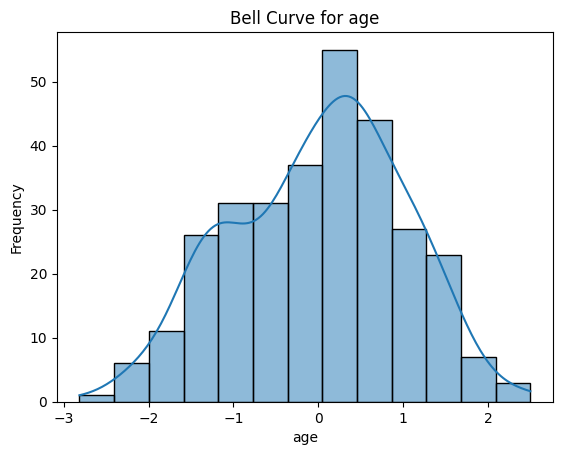

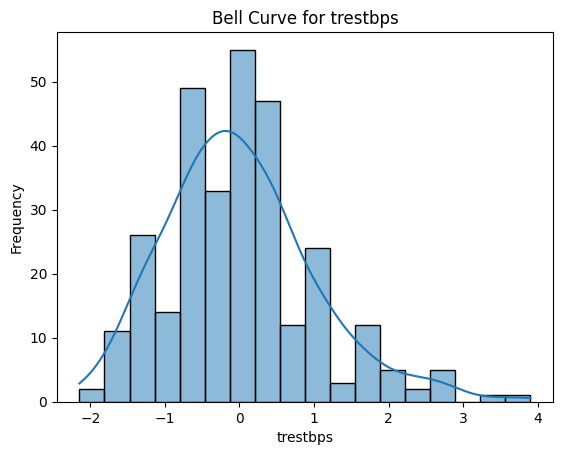

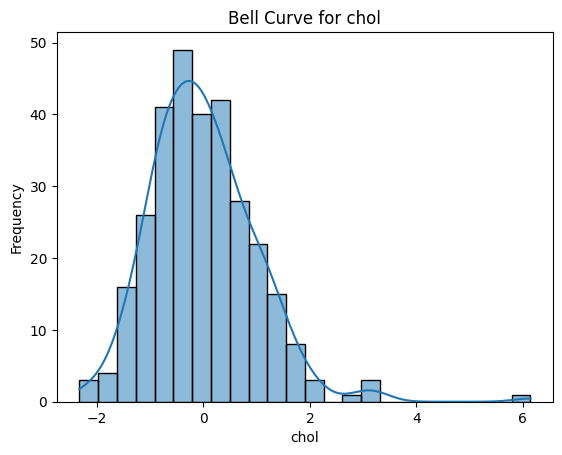

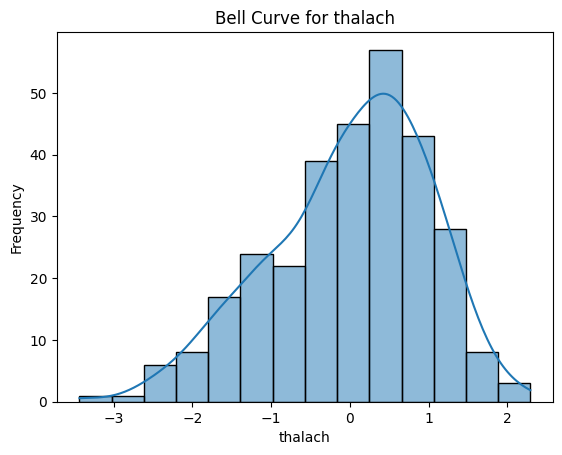

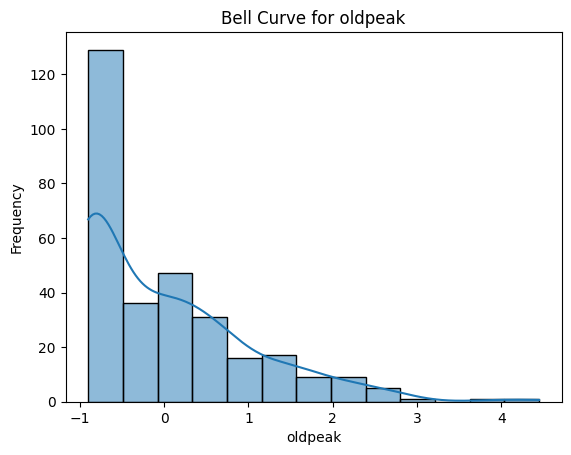

In [6]:

# Empirical Rule & Bell Curve
for col in continuous_features:
    sns.histplot(data[col], kde=True)
    plt.title(f"Bell Curve for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


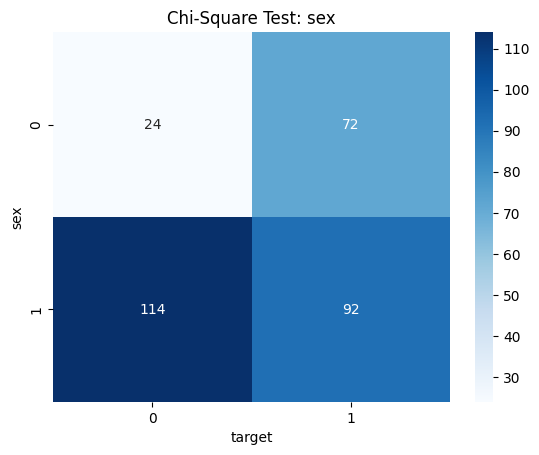

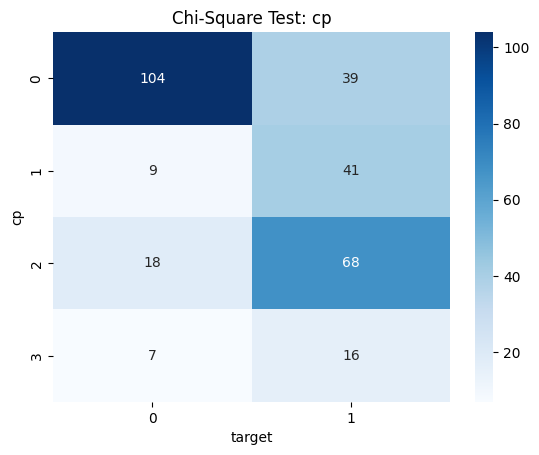

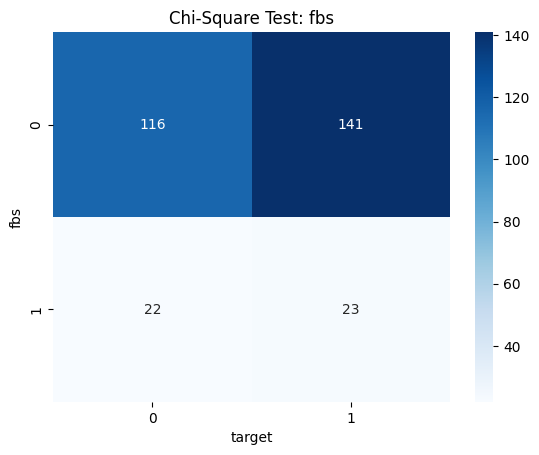

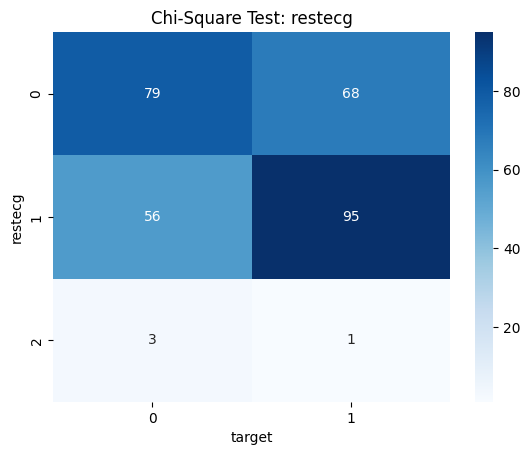

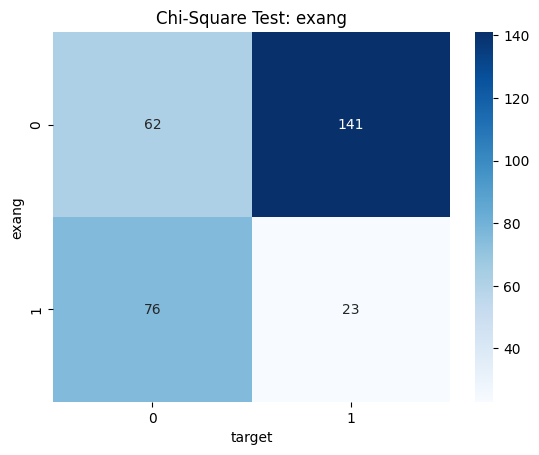

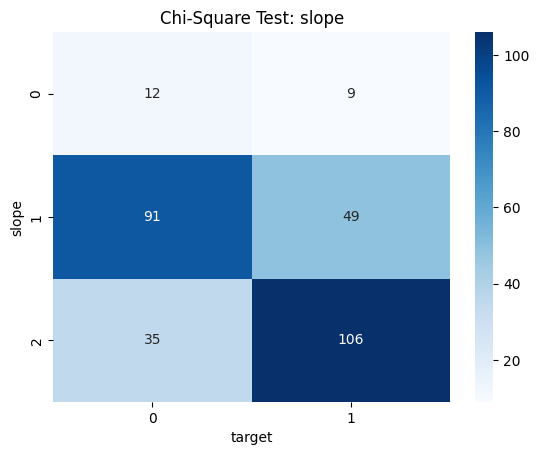

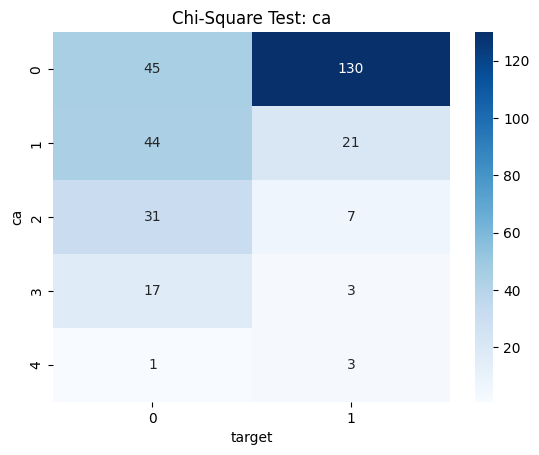

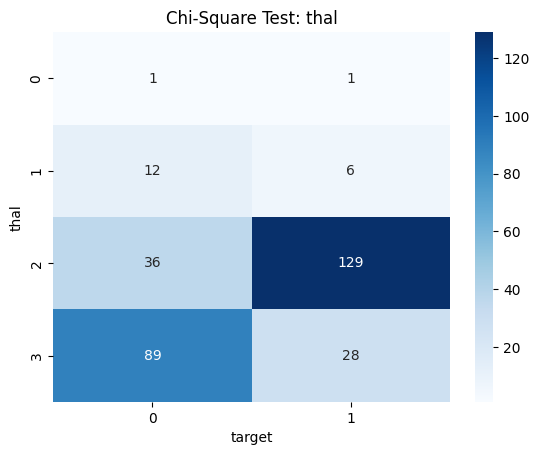


Significant Features (Chi-Square Test): ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [7]:

# Chi-Square Test
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
chi_square_results = {}
for col in categorical_features:
    contingency_table = pd.crosstab(data[col], data['target'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = (chi2_stat, p_value, dof)

    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Chi-Square Test: {col}")
    plt.show()
    # Print significant features
significant_features = [key for key, (chi2_stat, p_value, dof) in chi_square_results.items() if p_value < 0.05]
print("\nSignificant Features (Chi-Square Test):", significant_features)

ANOVA Test Results for thalach by cp:
F-statistic: 17.6202, Critical Value: 2.6349, P-value: 1.4799e-10



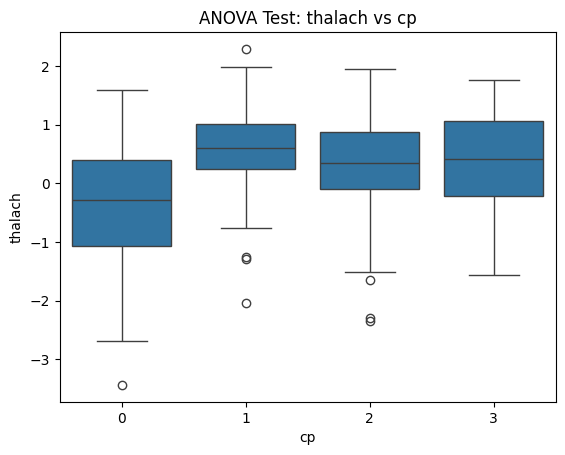

In [8]:

# ANOVA Test
categorical_feature = 'cp'
continuous_feature = 'thalach'
groups = [data[continuous_feature][data[categorical_feature] == category] for category in data[categorical_feature].unique()]
anova_result = f_oneway(*groups)
df_between = len(groups) - 1
df_within = data.shape[0] - len(groups)
critical_value = f.ppf(0.95, df_between, df_within)

print(f"ANOVA Test Results for {continuous_feature} by {categorical_feature}:")
print(f"F-statistic: {anova_result.statistic:.4f}, Critical Value: {critical_value:.4f}, P-value: {anova_result.pvalue:.4e}\n")

sns.boxplot(x=data[categorical_feature], y=data[continuous_feature])
plt.title(f"ANOVA Test: {continuous_feature} vs {categorical_feature}")
plt.show()



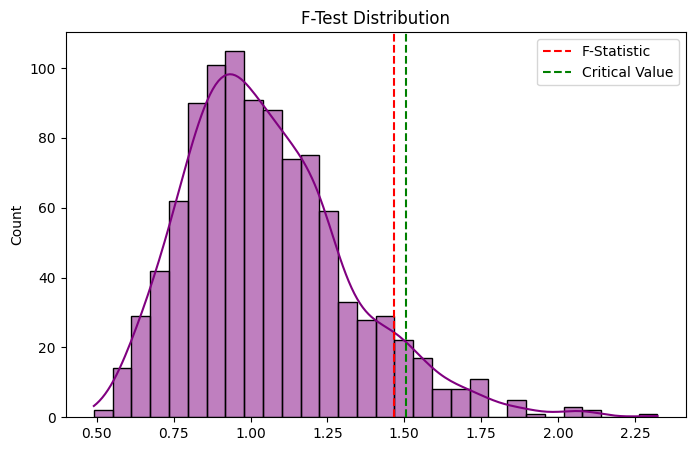

In [9]:
# F-Test for Variance
var_group1 = np.var(groups[0], ddof=1)
var_group2 = np.var(groups[1], ddof=1)
f_stat = var_group1 / var_group2
df1 = len(groups[0]) - 1
df2 = len(groups[1]) - 1
critical_value = f.ppf(0.95, df1, df2)

# F-Test Visualization
plt.figure(figsize=(8, 5))
sns.histplot(np.random.f(df1, df2, 1000), bins=30, kde=True, color='purple')
plt.axvline(f_stat, color='red', linestyle='--', label='F-Statistic')
plt.axvline(critical_value, color='green', linestyle='--', label='Critical Value')
plt.title('F-Test Distribution')
plt.legend()
plt.show()


PCA Reduced Dimensions: 5 components



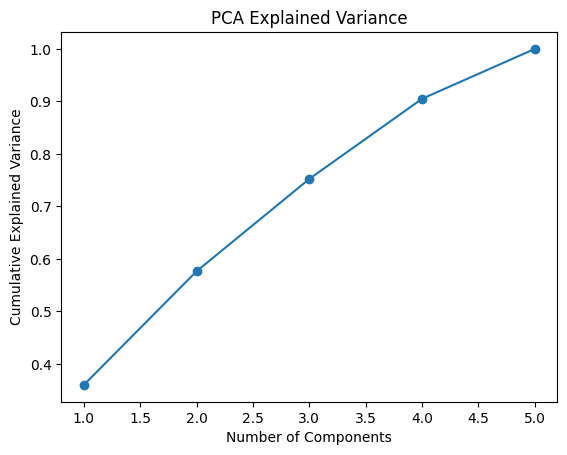

In [10]:

# PCA Analysis
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(data[continuous_features])
pca_variance = pca.explained_variance_ratio_

print(f"PCA Reduced Dimensions: {pca_data.shape[1]} components\n")

plt.plot(range(1, len(pca_variance) + 1), np.cumsum(pca_variance), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


In [11]:

# Feature Importance using Decision Tree
X = data.drop('target', axis=1)
y = data['target']
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)
feature_importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)


In [12]:

# Final Feature Selection
final_features = list(set(significant_features + feature_importances.index[:5].tolist()))
print("Final Selected Features:", final_features)


Final Selected Features: ['sex', 'chol', 'ca', 'exang', 'cp', 'restecg', 'thal', 'slope', 'oldpeak']


In [13]:

# Normalize Data using MinMaxScaler
minmax_scaler = MinMaxScaler()
data[continuous_features] = minmax_scaler.fit_transform(data[continuous_features])


In [14]:

print("Preprocessing Completed.")

Preprocessing Completed.


In [15]:
# Encode target variable into binary levels: 0 ('Good') and 1 ('Bad')
def categorize_target(value):
    return 0 if value == 0 else 1

data['target'] = data['target'].apply(categorize_target)

# Split dataset into training and testing
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [16]:
# Define KNN Model
k = 5  # Choose the number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)

# Train KNN Model
knn_model.fit(X_train, y_train)

# Make Predictions
y_pred = knn_model.predict(X_test)



In [17]:
# Compute Accuracy in Percentage
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"KNN Model Accuracy: {accuracy:.2f}%")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Good (0)', 'Bad (1)']))



KNN Model Accuracy: 77.05%
Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.77      0.71      0.74        28
     Bad (1)       0.77      0.82      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61




Confusion Matrix (Raw Format):
[[20  8]
 [ 6 27]]

TP: 27, TN: 20, FP: 8, FN: 6



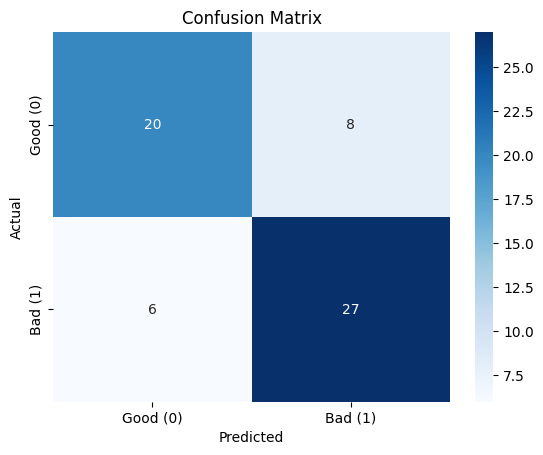

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print("\nConfusion Matrix (Raw Format):")
print(conf_matrix)

print(f"\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}\n")

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Good (0)', 'Bad (1)'], yticklabels=['Good (0)', 'Bad (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

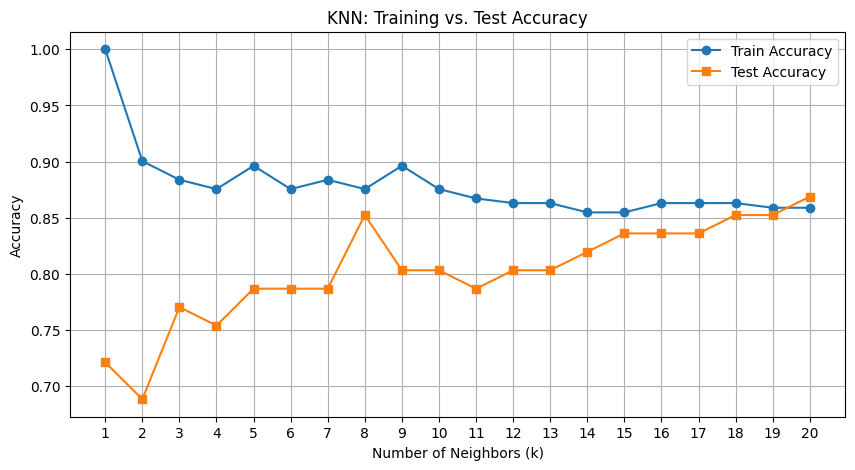

In [19]:
# Feature Scaling (Important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different k values and store accuracies
k_values = range(1, 21)
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    train_pred = knn.predict(X_train_scaled)
    test_pred = knn.predict(X_test_scaled)

    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

# Plot Accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(k_values, test_accuracies, label="Test Accuracy", marker='s')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN: Training vs. Test Accuracy")
plt.legend()
plt.xticks(k_values)
plt.grid()
plt.show()
